# Ensemble Model(csv v1)

In [1]:
#importing the required libraries libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
import numpy as np
import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


In [2]:
import logging

# importing boto3
from botocore.exceptions import ClientError

def initialize_s3_container(storage_name, locality=None):
    try:
        # if no locality is provided, use default aws region and create s3 client
        if locality is None:
            s3_service = boto3.client("s3")
            s3_service.create_bucket(Bucket=storage_name)
        else:
            s3_service = boto3.client("s3", region_name=locality)
            config_location = {"LocationConstraint": locality}
            s3_service.create_bucket(
                Bucket=storage_name, CreateBucketConfiguration=config_location
            )

    except ClientError as error_log:
        logging.error(error_log)
        return False
    #printing the message after successful creation
    print(f"S3 Bucket: {storage_name} has been successfully created.")
    return True

## Bucket Verification

In [3]:
#function to check if the bucket exists
def bucket_check(bucket_name):
    s3 = boto3.client("s3")
    try:
        #checking if the bucket exists using head_bucket
        s3.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
        return True
    except ClientError as e:
        #handling the 404 error if the bucket does not exist
        if e.response["Error"]["Code"] == "404":
            print(f"Bucket '{bucket_name}' does not exist.")
            return False
        else:
            #raising any other error if it occurs
            raise

## Bucket setup

In [4]:
## setting the s3 bucket name, fetching the s3 resource, checking if the bucket exists, and creating it if not
bucket_dsts = "u3268792-dsts-rohit-ensemble-1"
s3_instance = boto3.Session().resource("s3")
container_exists = bucket_check(bucket_dsts)
if not container_exists:
    initialize_s3_container(bucket_dsts)

Bucket 'u3268792-dsts-rohit-ensemble-1' does not exist.
S3 Bucket: u3268792-dsts-rohit-ensemble-1 has been successfully created.


In [5]:
# setting the prefix and defining a function to upload a csv file to aws s3

prefix = "oncloud"

def upload_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    print(s3_instance.Bucket(bucket_dsts))
    s3_instance.Bucket(bucket_dsts).Object(os.path.join(prefix, folder, filename)).put(
        Body=csv_buffer.getvalue()
    )

### Reading the data

In [6]:
#loading the data
df_v1 = pd.read_csv("./combined_csv_v1.csv")

print(df_v1.head())
print(df_v1.shape)

   target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0     689.0      False      False      False    False    False   
1     0.0     731.0      False      False      False    False    False   
2     0.0    1199.0      False      False      False    False    False   
3     0.0    1587.0      False      False      False    False    False   
4     0.0    1587.0      False      False      False    False    False   

   Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  \
0    False    False    False  ...     False     False      True     False   
1    False    False    False  ...     False     False     False     False   
2    False    False    False  ...      True     False     False     False   
3    False    False    False  ...     False     False     False     False   
4    False    False    False  ...     False     False     False     False   

   Dest_ORD  Dest_PHX  Dest_SFO  DepHourofDay_Morning  DepHourofDay_Afternoon  \
0     False

In [7]:
#creating the copy of the original data
df=df_v1.copy()

In [23]:
#converting all boolean values to 1 and 0
df = df.replace({True: 1, False: 0})

In [24]:
df.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
#checking the null values
df.isnull().sum()

target                    0
Distance                  0
Quarter_2                 0
Quarter_3                 0
Quarter_4                 0
                         ..
Dest_PHX                  0
Dest_SFO                  0
DepHourofDay_Morning      0
DepHourofDay_Afternoon    0
DepHourofDay_Evening      0
Length: 75, dtype: int64

### Split the dataset

In [26]:
#spliting the dataset into train, test and validation (70,15,15)
train, test_and_validate = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [27]:
#printing the shape
print(train.shape)
print(test.shape)
print(validate.shape)

(1144913, 75)
(245338, 75)
(245339, 75)


In [28]:
#changing the names for the files to upload to the bucket
train_file = "data_v1_train.csv"
test_file = "data_v1_test.csv"
validate_file = "data_v1_validate.csv"

In [29]:
#uploading each dataset subset to the specified S3 locations
upload_csv(train_file, "train", train)
upload_csv(test_file, "test", test)
upload_csv(validate_file, "validate", validate)

s3.Bucket(name='u3268792-dsts-rohit-ensemble-1')
s3.Bucket(name='u3268792-dsts-rohit-ensemble-1')
s3.Bucket(name='u3268792-dsts-rohit-ensemble-1')


In [30]:
#retrieving the amazon sagemaker container for the 'linear-learner' in the 'us-east-1' region
container = retrieve("xgboost", "us-east-1", version="1.0-1")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [31]:
#defining paramters
params={"num_round": "42", "eval_metric": "auc", "objective": "binary:logistic"}

In [32]:
# setting up the sagemaker session, output location, and xgboost model with paramters which we defined

session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))
s3_output_location = "s3://{}/{}/output/".format(bucket_dsts, prefix)
xgb_model = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    output_path=s3_output_location,
    hyperparameters=params,
    sagemaker_session=session,
)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [33]:
# setting up the training and validation input channels from s3, specifying content type as csv
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/{}".format(bucket_dsts, prefix, train_file), content_type="text/csv"
)

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/{}".format(bucket_dsts, prefix, validate_file), content_type="text/csv"
)

print(f"channels {validate_channel} \n {train_channel}")

data_channels = {"train": train_channel, "validation": validate_channel}


channels <sagemaker.inputs.TrainingInput object at 0x7f973de6a1d0> 


## Train the model

In [34]:
#fitting the model
xgb_model.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-04-08-16-06-487



2024-11-04 08:16:07 Starting - Starting the training job..
2024-11-04 08:16:23 Starting - Preparing the instances for training..
2024-11-04 08:16:42 Downloading - Downloading input data...
2024-11-04 08:16:57 Downloading - Downloading the training image.....
2024-11-04 08:17:28 Training - Training image download completed. Training in progress...........
2024-11-04 08:18:23 Uploading - Uploading generated training model.
2024-11-04 08:18:37 Completed - Training job completed


In [35]:
# deploying the trained xgboost model to an endpoint with specified instance settings and csv serializer
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.4xlarge",
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-04-08-19-02-936
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-11-04-08-19-02-936
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-11-04-08-19-02-936


------!

## Batch Data for Prediction

In [36]:
#preparing the input data for batch prediction by extracting all columns except the first one from the test set which is our target variable
batch_input_data = test.iloc[:, 1:]
batch_input_filename = "batch-for-ensemble.csv"

#uploading the prepared csv file to s3
upload_csv(batch_input_filename, "batch-in", batch_input_data)

s3.Bucket(name='u3268792-dsts-rohit-ensemble-1')


In [37]:
#setting up the s3 locations for batch input and output, and creating a transformer from the xgboost model with specified parameters

batch_output = "s3://{}/{}/batch-out/".format(bucket_dsts, prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket_dsts, prefix, batch_input_filename)

xgboost_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-04-08-22-52-216


In [38]:
#starting the batch transform job with input data and waiting for it to complete

xgboost_transformer.transform(
    data=batch_input, data_type="S3Prefix", content_type="text/csv", split_type="Line"
)

xgboost_transformer.wait()


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-04-08-22-54-658


.................................
[2024-11-04:08:28:26:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-04:08:28:26:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-04:08:28:26:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-04 08:28:26 +0000] [27] [INFO] Starting g

### Retrieving

In [41]:
#initializing the s3 client, retrieving the batch output file from s3, and reading it into a dataframe

s3 = boto3.client("s3")
obj = s3.get_object(
    Bucket=bucket_dsts, Key="{}/batch-out/{}".format(prefix, "batch-for-ensemble.csv.out")
)

target_predicted = pd.read_csv(io.BytesIO(obj["Body"].read()), names=["class"])


In [42]:
#function to convert predicted values to binary based on a threshold of 0.3
#if the value is greater than 0.3, it is classified as 1 (positive class)
#otherwise, it is classified as 0 (negative class)
def convert_to_binary(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

#applying the binary conversion to the "class" column of the predictions
#this step transforms continuous or probability predictions into binary values (0 or 1)
target_predicted_binary = target_predicted["class"].apply(convert_to_binary)



In [43]:
print(target_predicted_binary.head())

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


In [44]:
#extracting the test labels
test_labels_actual = test.iloc[:, 0]

test_labels_actual.head(5)

470151     0.0
985696     0.0
394886     0.0
924542     0.0
1533313    0.0
Name: target, dtype: float64

## Results

### Confusin Matrix

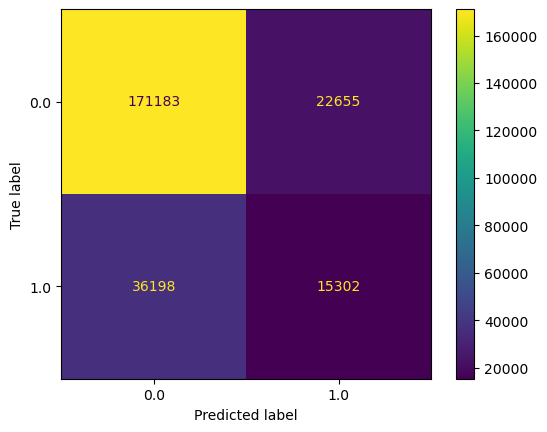

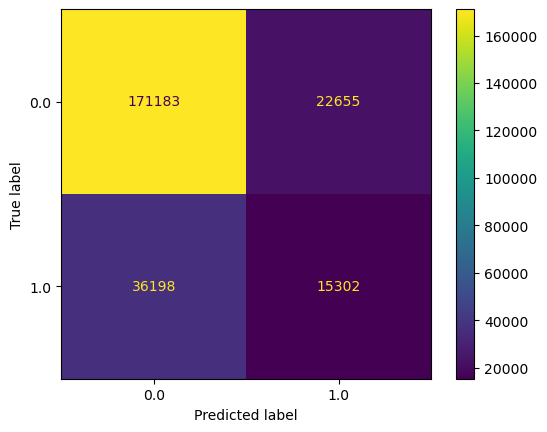

In [45]:
#plotting the confusion matrix
ConfusionMatrixDisplay.from_predictions(test_labels_actual, target_predicted_binary, cmap='viridis').plot()
plt.show()

### Classification Report

In [46]:
#classification report
print("Classification Report on Test Data")
print(classification_report(test_labels_actual, target_predicted_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85    193838
         1.0       0.40      0.30      0.34     51500

    accuracy                           0.76    245338
   macro avg       0.61      0.59      0.60    245338
weighted avg       0.74      0.76      0.75    245338

